In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# import sys
# sys.path.append('/content/drive/My Drive/Colab Notebooks/ml-1c')
# os.chdir('/content/drive/My Drive/Colab Notebooks/ml-1c')
# print(os.getcwd())

In [12]:
import os
import datetime
import numpy

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras import activations
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from cab420_a1c_q2_utils import *

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt     # for plotting
from tensorflow.keras import backend as K
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report





In [13]:
tf.__version__

'2.10.0-dev20220605'

In [14]:
label_info = {
    "gender":2,
    "torso_type":2,
    "torso_colour":11,
    "leg_type":2,
    "leg_colour":11,
    "luggage":2
}

In [40]:

train_x, train_y, test_x, test_y = load_data('Q2')
# plot_images_and_masks(train_x['images'], train_y['mask'])

print(train_x["images"].shape)
print(train_y["gender"].shape)
print(test_x["images"].shape)


(520, 100, 60, 3)
(520,)
(196, 100, 60, 3)


train val test split

In [41]:
validation_split = 0.1
train_size = int(train_x["images"].shape[0] * (1 - validation_split))
val_x = {"images": train_x["images"][train_size:,:]}
val_y = {}
for label in label_info:
    val_y[label] =  train_y[label][train_size:]
    train_y[label] = train_y[label][:train_size]

train_x["images"] = train_x["images"][:train_size,:]
print(train_y["gender"].shape)
print(val_y["gender"].shape)
468 + 52

(468,)
(52,)


520

## Explore Data

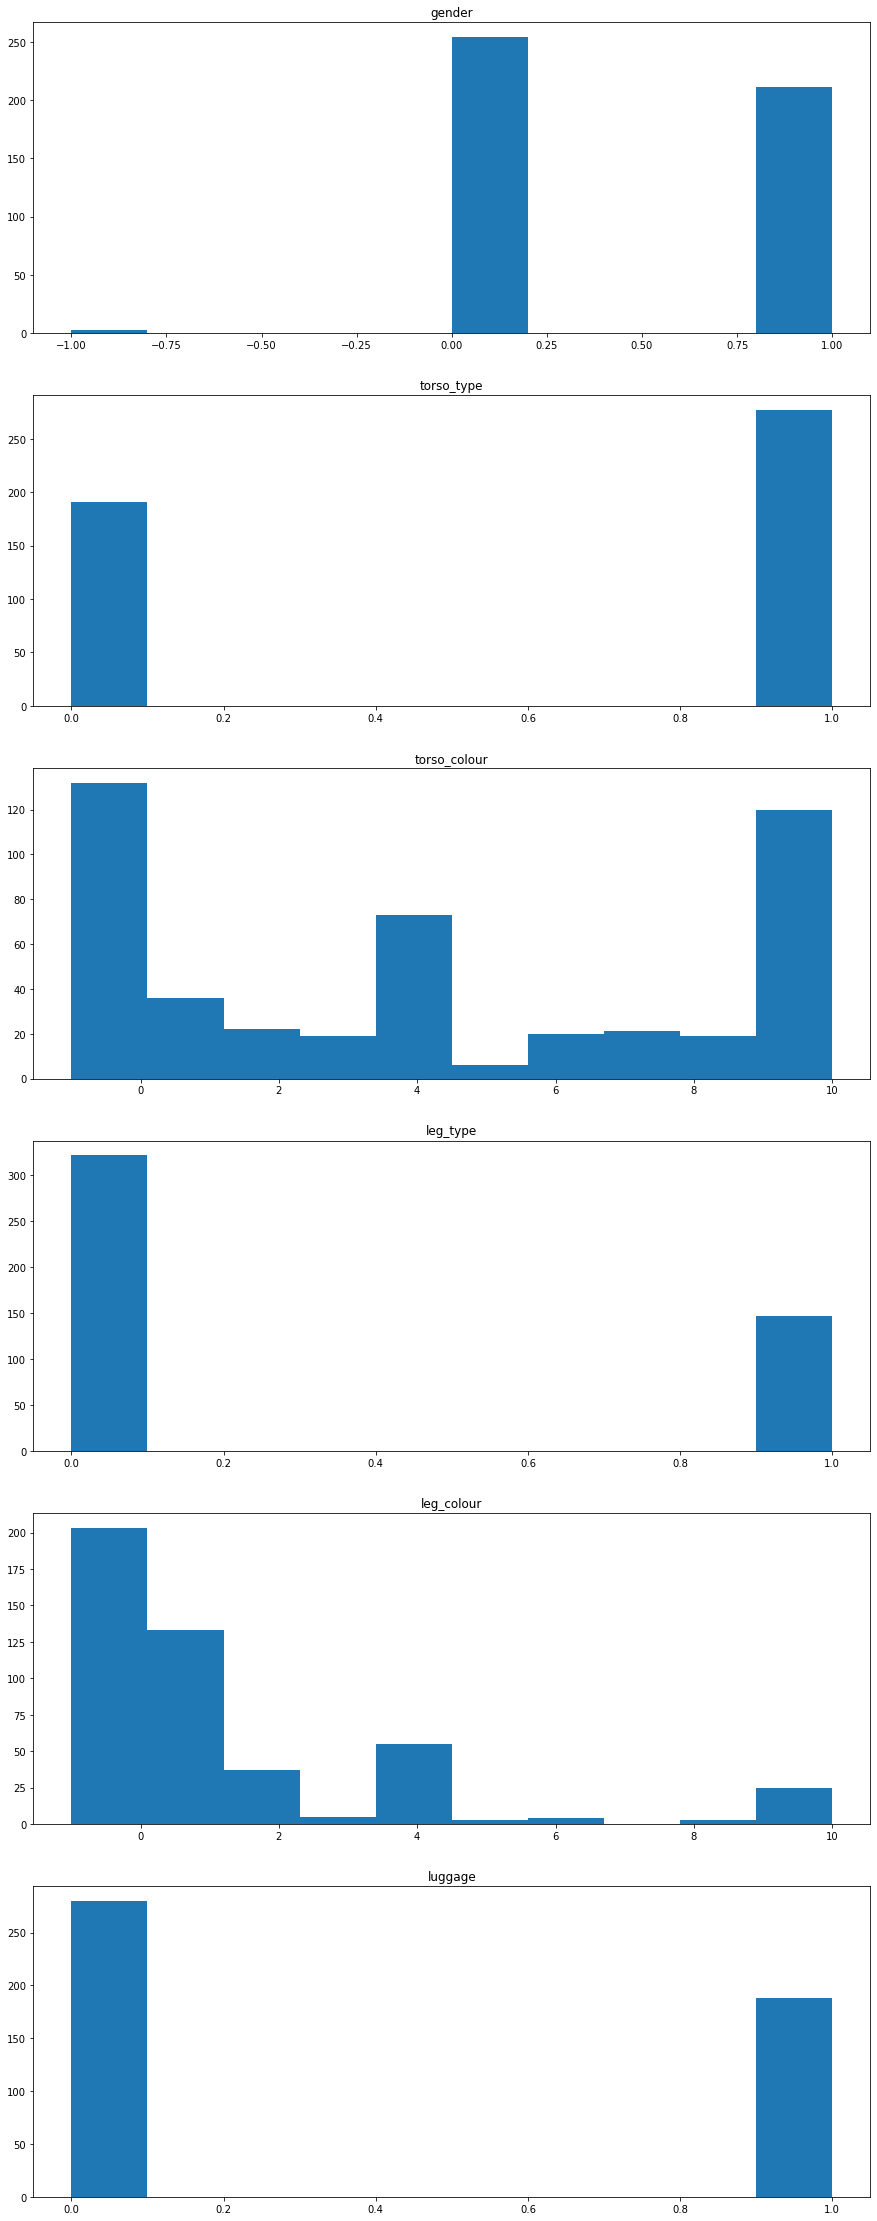

In [42]:
fig = plt.figure(figsize=(15,40))
for i, key in enumerate(label_info):
    ax = fig.add_subplot(6,1,1+i)
    ax.hist(train_y[key])
    ax.set_title(key)

Convert Y to one hot encoding

In [43]:
label_info

{'gender': 2,
 'torso_type': 2,
 'torso_colour': 11,
 'leg_type': 2,
 'leg_colour': 11,
 'luggage': 2}

In [44]:
def convert_to_one_hot(y_dict):
    one_hot_y = {}
    for label in label_info.keys():
        y = y_dict[label]
        # number of examples
        n = len(y)
        # the length of each one-hot vector
        length = label_info[label]

        one_hots = np.empty((n,length))
        for i in range(n):
            one_hot = np.zeros(shape=(length))
            val = y[i]
            if val == -1:
                one_hot[:] = -1
            else:
                one_hot[val] = 1
            one_hots[i,:] = one_hot
        print(one_hots.shape)
        one_hot_y[label] = one_hots
    return one_hot_y

one_hot_y = convert_to_one_hot(train_y)
one_hot_y_val = convert_to_one_hot(val_y)
one_hot_y_test = convert_to_one_hot(test_y)


(468, 2)
(468, 2)
(468, 11)
(468, 2)
(468, 11)
(468, 2)
(52, 2)
(52, 2)
(52, 11)
(52, 2)
(52, 11)
(52, 2)
(196, 2)
(196, 2)
(196, 11)
(196, 2)
(196, 11)
(196, 2)


Normalize input data

In [45]:
# train_x["images"]  = train_x["images"]/255.0
# val_x["images"] = val_x["images"]/255.0
# test_x["images"] = test_x["images"]/255.0

[array([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]]),
 array([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0

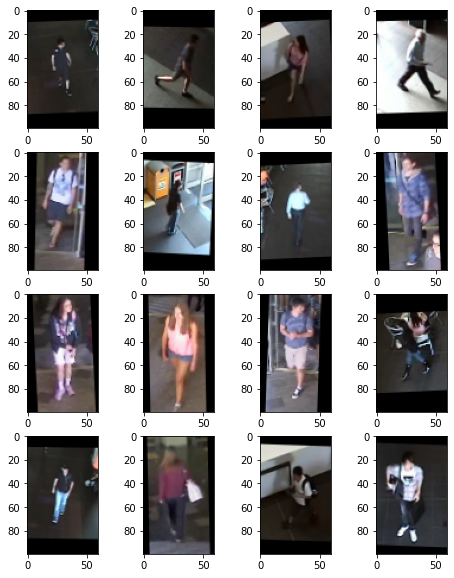

In [46]:
# Class for the data generator
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    
    # Input arguments are as follows:
    #  x:            our X data array that we'll augment
    #  y_one:        y labels for the first output
    #  y_two:        y labels for the second ouput
    #  data_aug:     our data augmentor
    #  batch_size:   the batch size to return from the generator
    #  dim:          size of images
    #  n_channels:   number of image channels
    #  shuffle:      flag to indicate if we should shuffle the data at the end of the epoch
    def __init__(self, x, y_labels, data_aug,                 
                 batch_size=32, dim=(28,28), n_channels=1,
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.x = x
        self.y_labels = y_labels
        self.data_aug = data_aug
        self.list_IDs = np.arange(0, self.x.shape[0])
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

    # Function to generate data. This will take in a list of sample indicies, and then for each
    # these apply augmentation, and return the augmented data and labels
    #
    # If you wish to check the mechanics out in more detail, you can uncomment the two print lines
    # which will show you the IDs that are being manipulated and help show what's going on - however
    # this will also generate a lot of output text during model training.
    #
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization - creating space for X and y data
#        print(list_IDs_temp)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        # creating a list of empty arrays to hold our data labels. 
        # would initialise this for the number of output labels we have
        y = []
        for k in self.y_labels.keys():
            y.append(np.empty((self.batch_size, len(self.y_labels[k][0]))))
        # y = [np.empty((self.batch_size), dtype=int),
        #      np.empty((self.batch_size), dtype=int)]
        # Generate data, loop through the list of IDs we have and generate data for each in turn
        for i, ID in enumerate(list_IDs_temp):
#            print(ID)
            # apply random transformation based of our datagen instance
            X[i,] = self.data_aug.random_transform(self.x[ID,])
            # copy our y labels across
            for j,k in enumerate(self.y_labels.keys()):
                # print(y[j][i])
                # print(self.y_labels[k][ID].shape)
                y[j][i,] = self.y_labels[k][ID]

            # y[0][i,] = self.y_one[ID]
            # y[1][i,] = self.y_two[ID]
        return X, y

# creating image aug with some really wild and extreme augmentation params
# Ad noted above: these params are not suitable, just used to demo it in practice
data_aug = ImageDataGenerator(
                            # rotate between -45, +45 degrees
                            rotation_range=3,
                            # horiziontal shift by +/- 50% of the image width
                            width_shift_range=0.01,
                            # vertical shift by +/- 50% of the image width
                            height_shift_range=0.01,
                            # range for zooming
                            zoom_range=0.01,
                            # allow horizontal flips of data
                            horizontal_flip=True,
                            )

y_labels = []
for k in list(train_y.keys())[:-1]:
    y_labels.append(one_hot_y[k])


# create generator for our dataset

datagen = DataGenerator(train_x["images"], one_hot_y, data_aug,dim=(100,60),n_channels=3 ,batch_size=16)
# lets just test how it works
# will just get a random batch from here (just pick the first one)
x_, y_ = datagen[1]
fig = plt.figure(figsize=[8, 10])
for i in range(0, 16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(x_[i,:])
y_

In [47]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v2(inputs, filters, num_res_blocks, pool_size):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.

    # Arguments
        inputs (layer):         the input tensor
        filters ([int]):        number of filters in each stage, length of list determines number of stages
        num_res_blocks (int):   number of residual blocks per stage
        pool_size (int):        size of the average pooling at the end

    # Returns
        output after global average pooling and flatten, ready for output
    """

    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0],
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage, filters in enumerate(filters):
        num_filters_in = filters
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    return y

In [48]:
# semi-supervised cateogorical cross entropy loss. This wil find any rows that have a -1 in the labels
# and remove them from consideration
def masked_cce(y_true, y_pred):
    y_true_masked = tf.boolean_mask(y_true, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    y_pred_masked = tf.boolean_mask(y_pred, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    return K.mean(K.categorical_crossentropy(y_true_masked, y_pred_masked, from_logits=True))

In [26]:
label_info.keys()

dict_keys(['gender', 'torso_type', 'torso_colour', 'leg_type', 'leg_colour', 'luggage'])

In [49]:
image_shape = (100, 60, 3,)
def build_model():
    inputs = Input(shape=image_shape, name="img")
    base_model = resnet_v2(inputs, [8, 16, 32], 3, 4)
    outputs = []
    for label in label_info.keys():
        x = Dense(64, name=f"pre-{label}-1", activation="relu")(base_model)
        x = Dense(32, name=f"pre-{label}-2", activation="relu")(x)
        x = Dense(16, name=f"pre-{label}-3", activation="relu")(x)

        output = Dense(label_info[label], name=label)(x)
        outputs.append(output)
    
    model_resnet_v2 = keras.Model(inputs=inputs, outputs=outputs, name="simple_resnet_v2")
    model_resnet_v2.compile(loss=[masked_cce]*len(label_info),optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model_resnet_v2.fit(datagen,  epochs=100, callbacks=[callback], validation_data=(val_x["images"],list(one_hot_y_val.values())))
    return model_resnet_v2, history
model, history = build_model()
model.save("Q2_model")


Epoch 1/100
29/29 [==============================] - 31s 519ms/step - loss: 6.9743 - gender_loss: 0.7157 - torso_type_loss: 0.6997 - torso_colour_loss: 2.2222 - leg_type_loss: 0.7245 - leg_colour_loss: 1.7515 - luggage_loss: 0.6884 - gender_accuracy: 0.5086 - torso_type_accuracy: 0.5690 - torso_colour_accuracy: 0.2392 - leg_type_accuracy: 0.6401 - leg_colour_accuracy: 0.3858 - luggage_accuracy: 0.5668 - val_loss: 11.5843 - val_gender_loss: 0.7058 - val_torso_type_loss: 1.4957 - val_torso_colour_loss: 3.1210 - val_leg_type_loss: 1.7108 - val_leg_colour_loss: 3.6049 - val_luggage_loss: 0.7743 - val_gender_accuracy: 0.5000 - val_torso_type_accuracy: 0.4615 - val_torso_colour_accuracy: 0.2308 - val_leg_type_accuracy: 0.6731 - val_leg_colour_accuracy: 0.2500 - val_luggage_accuracy: 0.5385
Epoch 2/100
29/29 [==============================] - 13s 429ms/step - loss: 6.3932 - gender_loss: 0.6953 - torso_type_loss: 0.6942 - torso_colour_loss: 2.0140 - leg_type_loss: 0.6289 - leg_colour_loss: 1.5

INFO:tensorflow:Assets written to: Q2_model/assets


INFO:tensorflow:Assets written to: Q2_model/assets


In [40]:
model.summary()

Model: "simple_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 100, 60, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_53 (Conv2D)             (None, 100, 60, 8)   224         ['img[0][0]']                    
                                                                                                  
 batch_normalization_49 (BatchN  (None, 100, 60, 8)  32          ['conv2d_53[0][0]']              
 ormalization)                                                                                    
                                                                                   

In [35]:
predictions = model.predict(test_x["images"])

7/7 [==============================] - 2s 154ms/step


In [36]:
print(predictions[0])
test_y["gender"]

[[-4.08325577e+00  1.32556796e+00]
 [ 1.73817170e+00 -1.80851489e-01]
 [ 5.33826470e-01  3.72593611e-01]
 [ 3.65032732e-01 -3.00761491e-01]
 [-4.31916142e+00  6.69532359e-01]
 [-2.05213279e-01 -4.39555317e-01]
 [ 1.84381694e-01 -9.60138798e-01]
 [ 4.57222939e-01 -5.33430338e-01]
 [ 3.81306499e-01 -1.24298263e+00]
 [-2.90539801e-01 -1.41033554e+00]
 [ 1.91088557e-01  3.20894092e-01]
 [-1.95239484e-01  1.14064164e-01]
 [-2.37926745e+00 -4.70314473e-01]
 [-1.02498606e-02 -7.49958456e-01]
 [-3.78446221e+00  2.28645056e-01]
 [ 8.34183574e-01 -3.86519819e-01]
 [-1.24337263e-01 -6.89603329e-01]
 [ 1.07614622e-02 -1.50421429e+00]
 [-1.02680504e+00  9.64071527e-02]
 [-1.51574898e+00  9.67568696e-01]
 [-1.12948455e-01 -3.06547076e-01]
 [ 3.53073657e-01 -1.25741267e+00]
 [-1.52206349e+00  1.13540721e+00]
 [ 3.93164605e-01 -1.80052191e-01]
 [ 3.64254266e-01 -2.86756977e-02]
 [ 2.42719382e-01 -7.80792952e-01]
 [-9.30395126e-01  3.27250749e-01]
 [-2.17035294e+00  1.79758596e+00]
 [-2.57179046e+00  6

array([ 0,  0,  0,  1,  1,  0,  0,  1,  0,  1,  1,  0,  1,  0,  1,  1,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0,  1,  0,  0,  0,  1,
        1,  0,  1,  1,  1, -1,  1, -1,  0,  1,  0,  0,  1,  1,  1,  1, -1,
        1, -1,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0, -1,  0,  0,  1,
        0,  1,  1,  1,  1,  0,  1,  1,  1,  0,  0,  1,  0,  1,  1,  1,  1,
        1,  0,  1,  0,  1,  0,  0,  1,  1,  1,  1,  1,  0,  1,  1,  1, -1,
        0,  0,  0,  1,  1,  0,  0,  1,  1,  0,  0,  0,  1,  0,  1,  0,  1,
        1,  1,  1,  1,  0,  1,  1,  0,  0,  1,  0,  1,  0,  0,  0,  1,  1,
        1,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  1,
        1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  0,
        1,  1,  0,  0,  1,  0,  1,  0,  0, -1,  0,  1,  0,  1,  1,  1,  0,
        0,  1,  1,  0,  0,  1,  0,  0,  0])

7/7 [==============================] - 1s 163ms/step

start====================gender====================
              precision    recall  f1-score   support

           0       0.60      0.67      0.63       106
           1       0.55      0.47      0.50        90

    accuracy                           0.58       196
   macro avg       0.57      0.57      0.57       196
weighted avg       0.57      0.58      0.57       196

end====================gender====================

start====================torso_type====================
              precision    recall  f1-score   support

           0       0.40      0.45      0.43        75
           1       0.63      0.58      0.60       121

    accuracy                           0.53       196
   macro avg       0.52      0.52      0.51       196
weighted avg       0.54      0.53      0.54       196

end====================torso_type====================

start====================torso_colour====================
              precis

/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



start====================leg_colour====================
              precision    recall  f1-score   support

           0       0.52      0.94      0.67        69
           1       0.57      0.48      0.52        63
           2       0.50      0.12      0.20         8
           3       0.00      0.00      0.00         7
           4       0.50      0.26      0.34        27
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.50      0.08      0.13        13
          10       0.00      0.00      0.00         1

    accuracy                           0.53       196
   macro avg       0.26      0.19      0.19       196
weighted avg       0.49      0.53      0.47       196

end====================leg_colour====================

start====================luggage====================
              precision    recall  f1-score   support

           0       0.

/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/cab420-env/

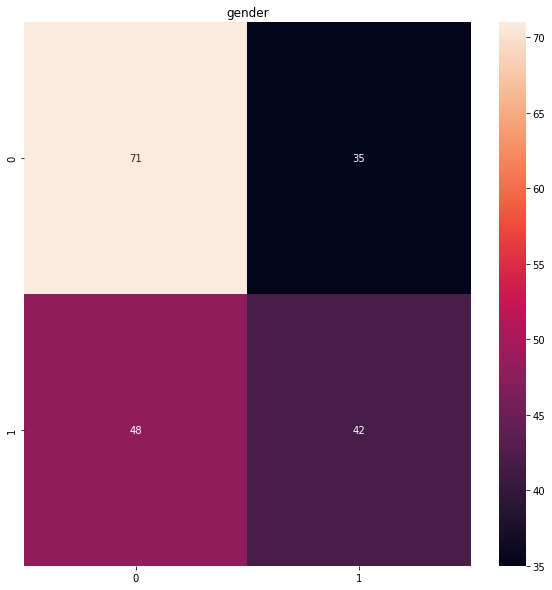

<Figure size 720x576 with 0 Axes>

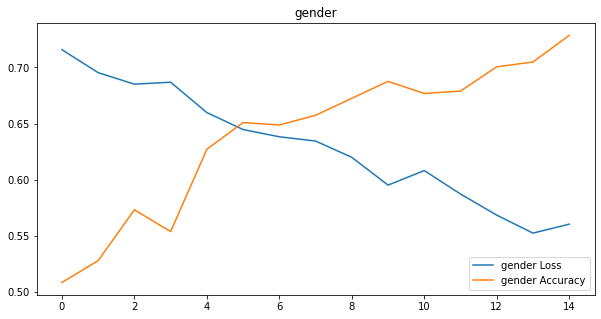

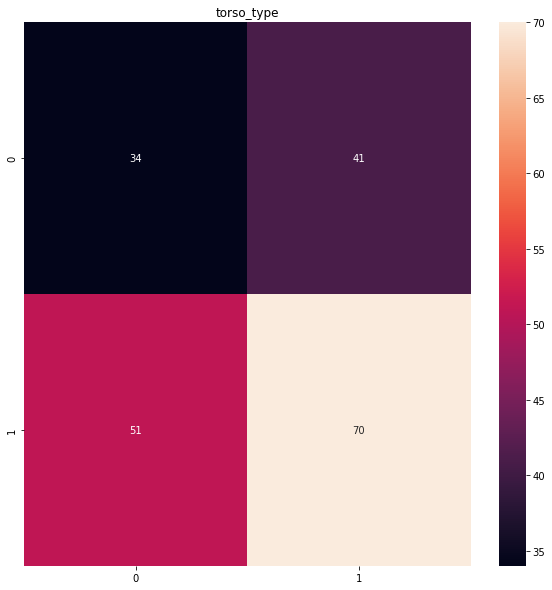

<Figure size 720x576 with 0 Axes>

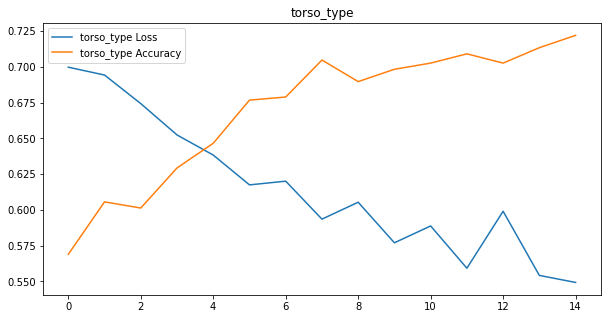

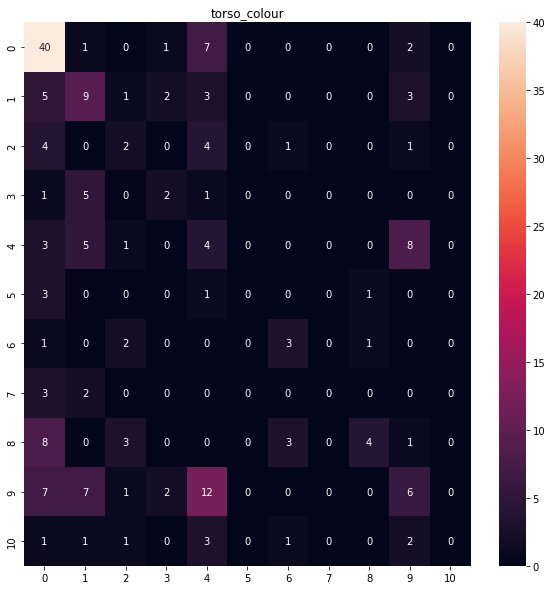

<Figure size 720x576 with 0 Axes>

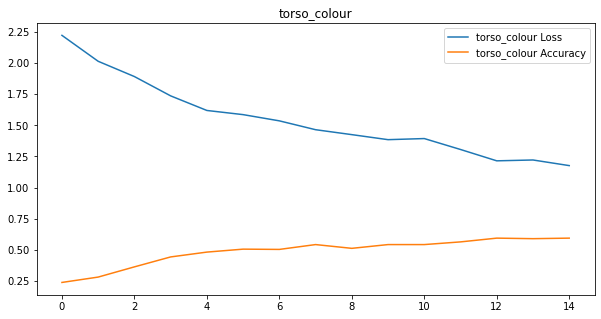

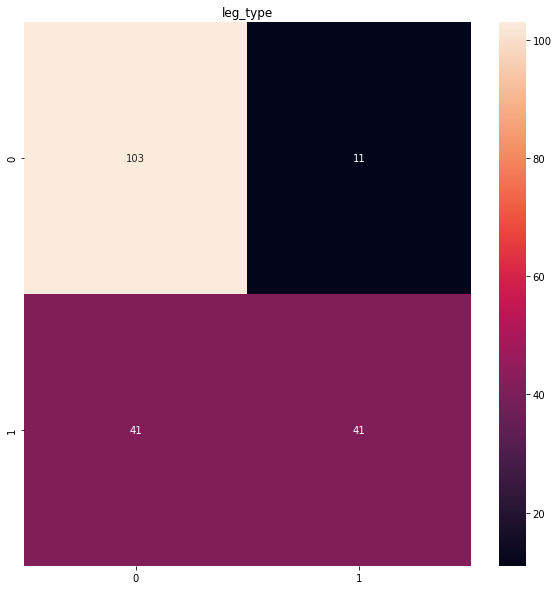

<Figure size 720x576 with 0 Axes>

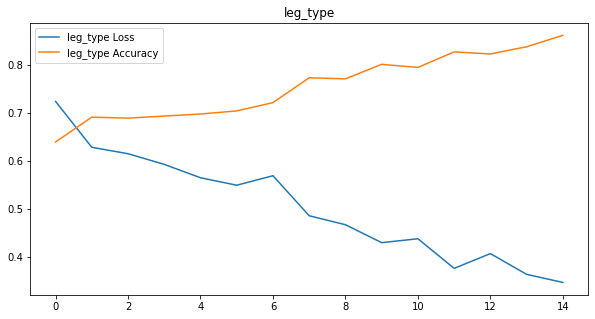

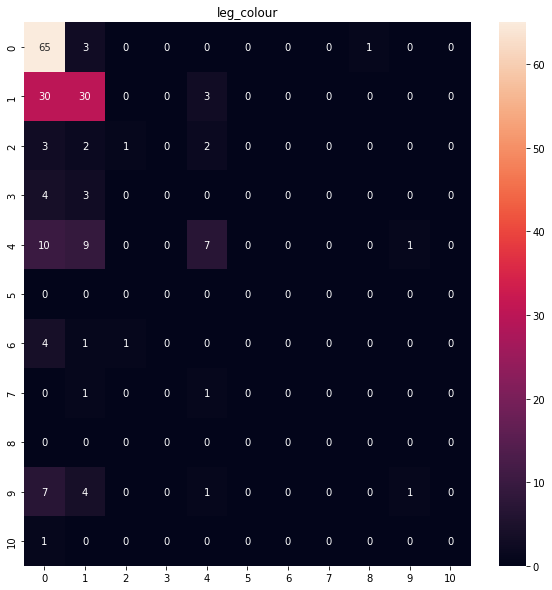

<Figure size 720x576 with 0 Axes>

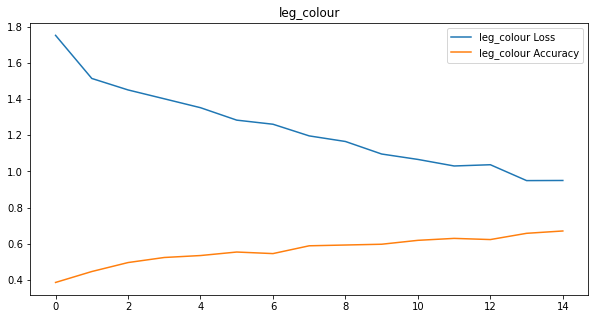

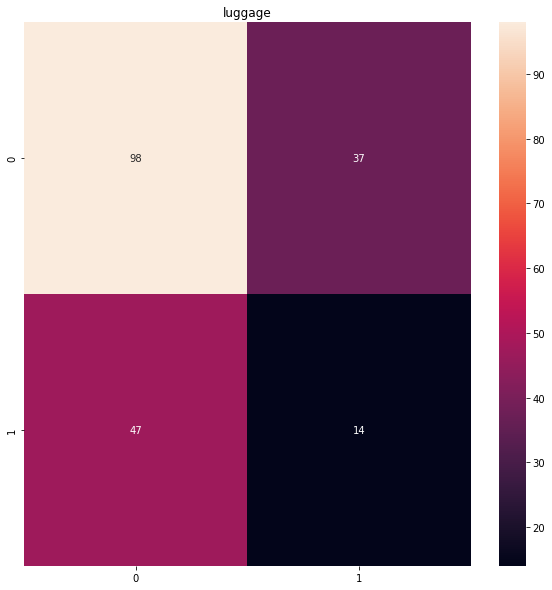

<Figure size 720x576 with 0 Axes>

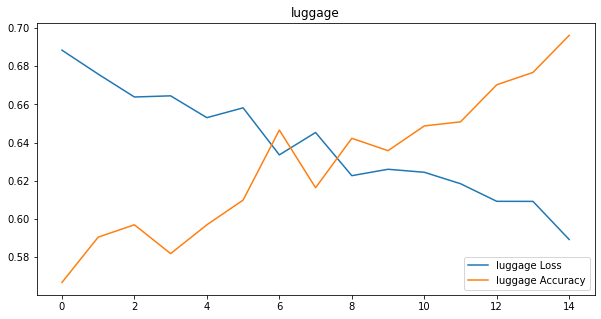

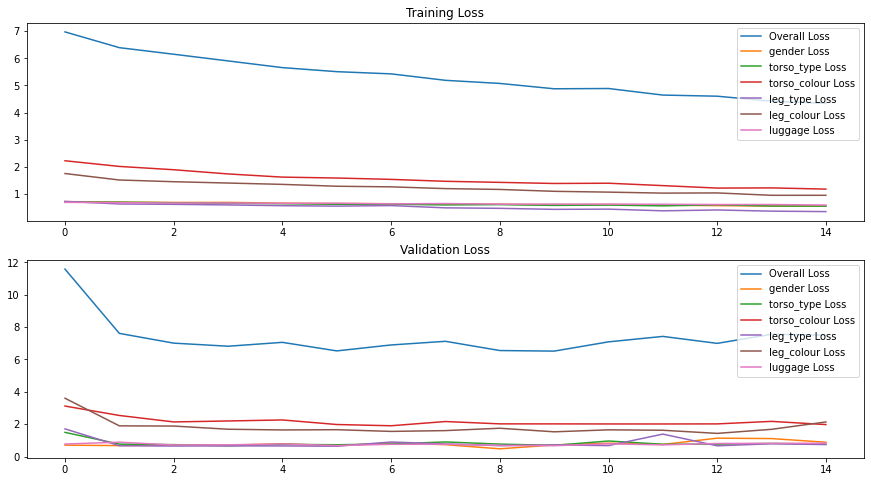

In [52]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

def eval_model(model, history, x_test, y_test):


    preds = model.predict(x_test);
    for i, pred in enumerate(preds):
        fig = plt.figure(figsize=[10, 10])    

        ax = fig.add_subplot(1, 1, 1)    
        class_name = list(label_info.keys())[i]
     
        indexes = tf.argmax(pred, axis=1)
        gt_idx = tf.argmax(y_test[i], axis=1)

        confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_mtx, xticklabels= range((list(label_info.values()))[i]) , yticklabels=range((list(label_info.values()))[i]), 
                annot=True, fmt='g', ax=ax)
        ax.set_title(class_name)                
        print()
        print(("start"+"="*20) +class_name+("="*20))
        print(classification_report(gt_idx, indexes))
        print(("end"+"="*20) +class_name+("="*20))

        

        fig = plt.figure(figsize=[10, 5])    

        ax = fig.add_subplot(1, 1, 1)    
        ax.plot(history[f'{class_name}_loss'], label=f'{class_name} Loss')
        ax.plot(history[f'{class_name}_accuracy'], label=f'{class_name} Accuracy')
        ax.set_title(class_name)
        ax.legend()

    fig = plt.figure(figsize=[15, 8])
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(history['loss'], label = 'Overall Loss')
    for label in label_info:
        ax.plot(history[f'{label}_loss'], label = f'{label} Loss')
    ax.legend()
    ax.set_title('Training Loss')

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(history['val_loss'], label = 'Overall Loss')
    for label in label_info:
        ax.plot(history[f'val_{label}_loss'], label = f'{label} Loss')
    
    ax.legend()
    ax.set_title('Validation Loss')

ys = list(one_hot_y_test.values())
eval_model(model, history.history,x_test=test_x["images"], y_test=ys)

In [58]:
prediction = model.predict(test_x["images"])

7/7 [==============================] - 2s 269ms/step


|Class|Predicted|Actual|
|--|--|--|
|gender|	1	|0|
|torso_type|	0	|0|
|torso_colour|	0	|4|
|leg_type|	0	|0|
|leg_colour|	0	|0|
|luggage|	0	|1|


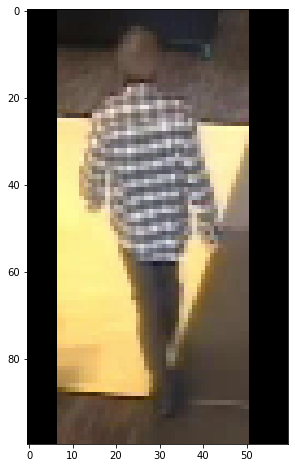

In [84]:
user_id = 18
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(test_x["images"][user_id,:])
print("|Class|Predicted|Actual|")
print("|--|--|--|")
for i, pred in enumerate(prediction):

    class_name = list(label_info.keys())[i]
    pred_y = tf.argmax(pred, axis=1)[user_id]
    real_y = test_y[class_name][user_id]

    print(f"|{class_name}|\t{pred_y}\t|{real_y}|")


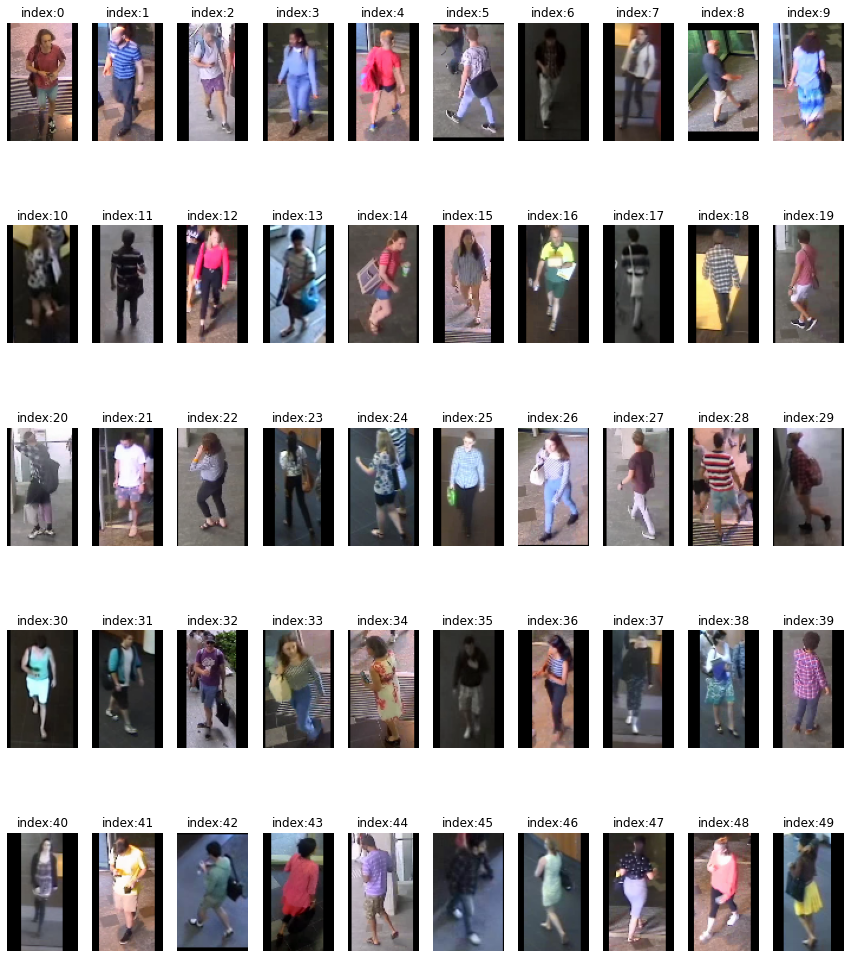

In [62]:
plot_images(test_x["images"])